In [1]:
import gymnasium as gym
import numpy as np
import text_flappy_bird_gym
import copy
import matplotlib.pyplot as plt
import ast

# Monte Carlo Control based agent

In [2]:

class MC_agent():
    def __init__(self, env, num_episodes=10000, max_steps_for_episode=1000, gamma=0.9, eps_start=1.0, eps_decay=0.999, eps_min=0.05):
        self.env = env
        self.nA = env.action_space.n
        self.Q = {}
        self.N = {}
        self.policy = {}
        self.gamma = gamma
        self.eps_min = eps_min
        self.eps_decay = eps_decay
        self.epsilon = eps_start
        self.episodes = num_episodes
        self.max_steps = max_steps_for_episode

    def get_action(self, state):
        if str(state) not in self.policy:
            self.policy[str(state)] = np.random.choice(range(self.nA))
        if np.random.rand() > self.epsilon:
            return self.policy[str(state)]
        else:
            return np.random.choice(range(self.nA))

    def generate_episode(self):
        episode = []
        state,_ = self.env.reset()
        for _ in range(self.max_steps):
            action = self.get_action(state)
            next_state, reward, done, _, info = self.env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        return episode

    def update_Q(self, episode):
        G = 0
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = self.gamma * G + reward
            if str(state) not in self.Q:
                self.Q[str(state)] = np.zeros(self.nA)
            if str(state) not in self.N:
                self.N[str(state)] = np.zeros(self.nA)
            self.N[str(state)][action] += 1
            self.Q[str(state)][action] += (1 / self.N[str(state)][action]) * (G - self.Q[str(state)][action])

    def update_policy(self):
        for state in self.Q:
            self.policy[str(state)] = np.argmax(self.Q[str(state)])

    def train(self):
        for episode in range(self.episodes):
            episode = self.generate_episode()
            self.update_Q(episode)
            self.update_policy()
            self.epsilon = max(self.epsilon * self.eps_decay, self.eps_min)

# Sarsa($\lambda$) agent according to 12.7 of the book

In [3]:
class SARSA_agent():
    def __init__(self, env, num_episodes=10000, max_steps_for_episode=1000, gamma=0.9, alpha=0.1, epsilon=0.1, lambd=0.9):
        self.env = env
        self.nA = env.action_space.n
        self.Q = {}
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.lambd = lambd
        self.episodes = num_episodes
        self.max_steps = max_steps_for_episode

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(range(self.nA))
        else:
            return self.policy(state)  #

    def policy(self, state):
        if str(state) in self.Q:
            return np.argmax(self.Q[str(state)])
        else:
            return np.random.choice(range(self.nA))

    def train(self):
        for _ in range(self.episodes):
            eligibility_trace = {} 
            state,_ = self.env.reset()
            if str(state) not in self.Q:
                self.Q[str(state)] = np.zeros(self.nA)
            action = self.get_action(state)
            for _ in range(self.max_steps):
                next_state, reward, done, _, info = self.env.step(action)
                next_action = self.get_action(next_state)
                if str(state) not in eligibility_trace:
                    eligibility_trace[str(state)] = np.zeros(self.nA)
                eligibility_trace[str(state)][action] += 1
                if str(next_state) not in self.Q:
                    self.Q[str(next_state)] = np.zeros(self.nA)
                delta = reward + self.gamma * self.Q[str(next_state)][next_action] - self.Q[str(state)][action]
                self.Q[str(state)][action] += self.alpha * delta * eligibility_trace[str(state)][action]
                eligibility_trace[str(state)] *= self.gamma * self.lambd
                state = next_state
                action = next_action
                if done:
                    break

# Learn

In [13]:
mc = MC_agent(gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4))
mc.train()

In [14]:
sarsa = SARSA_agent(gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4))
sarsa.train()

In [15]:
mc.epsilon=0
sarsa.epsilon=0

# Test

In [16]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
state,_ = env.reset()
done = False
while not done:
    action = mc.get_action(state)
    state, _, done, _, info = env.step(action)
    if done:
        break
    if info['score'] == 100:
        print('MC agent reached score 100, lets stop')
        break
print('MC agent reached score', info['score'])

MC agent reached score 100, lets stop
MC agent reached score 100


In [17]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
state,_ = env.reset()
done = False
while not done:
    action = sarsa.get_action(state)
    state, _, done, _, info = env.step(action)
    if done:
        break
    if info['score'] == 100:
        print('SARSA agent reached score 100, lets stop')
        break

print('SARSA agent reached score', info['score'])

SARSA agent reached score 42


# Plot state value

In [18]:
Q_mc = copy.deepcopy(mc.Q)
V_mc = dict((k,np.max(v)) for k, v in Q_mc.items())
Q_sarsa = copy.deepcopy(sarsa.Q)
V_sarsa = dict((k,np.max(v)) for k, v in Q_sarsa.items())

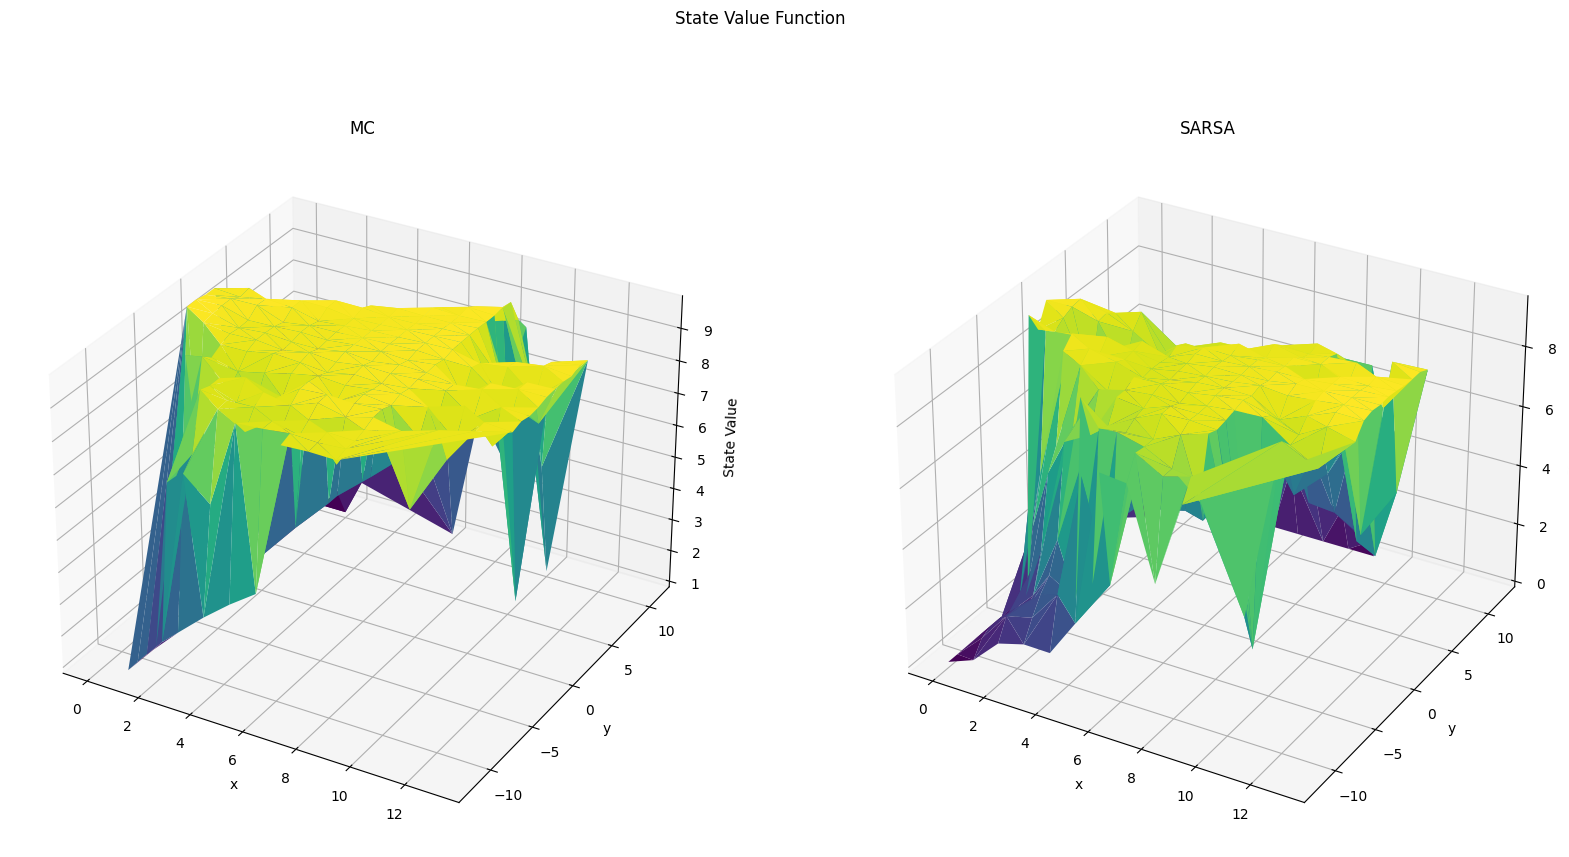

In [19]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax.set_title('MC')
ax2.set_title('SARSA')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('State Value')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('State Value')
ax.plot_trisurf([ast.literal_eval(k)[0] for k in V_mc.keys()], [ast.literal_eval(k)[1] for k in V_mc.keys()], list(V_mc.values()), cmap='viridis')
ax2.plot_trisurf([ast.literal_eval(k)[0] for k in V_sarsa.keys()], [ast.literal_eval(k)[1] for k in V_sarsa.keys()], list(V_sarsa.values()), cmap='viridis')
plt.suptitle('State Value Function')
plt.show()


# Parameter sweep : lets see how does the agent perform with smaller pipe gap

In [7]:
mc1 = MC_agent(gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 1))
mc1.train()

In [8]:
sarsa1 = SARSA_agent(gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 1))
sarsa1.train()

In [20]:
mc1.epsilon=0
sarsa1.epsilon=0

In [22]:
Q_mc1 = copy.deepcopy(mc1.Q)
V_mc1 = dict((k,np.max(v)) for k, v in Q_mc1.items())
Q_sarsa1 = copy.deepcopy(sarsa1.Q)
V_sarsa1 = dict((k,np.max(v)) for k, v in Q_sarsa1.items())

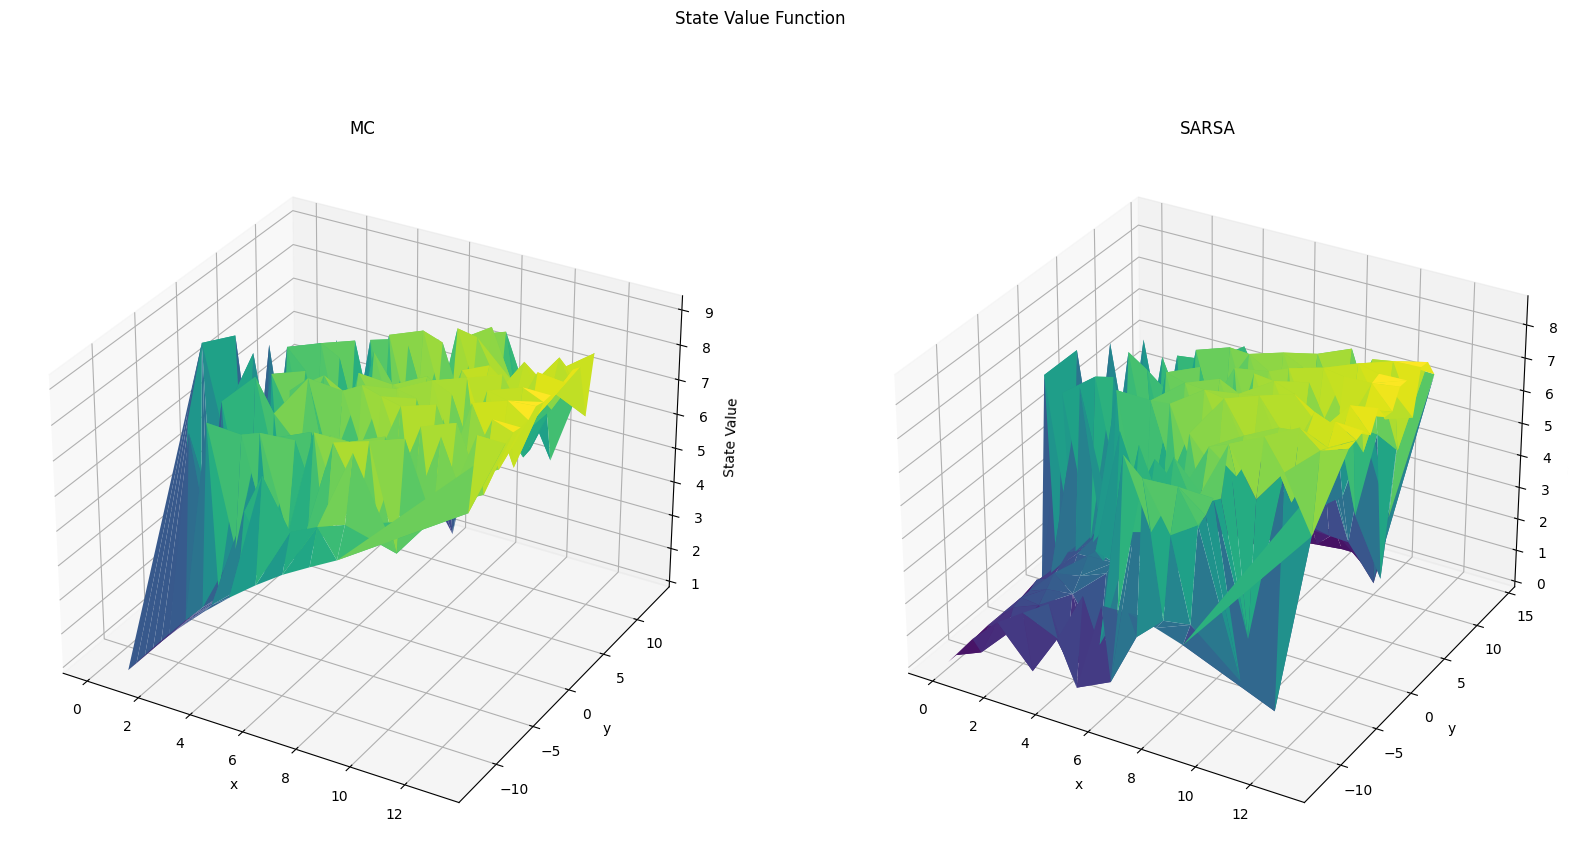

In [23]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax.set_title('MC')
ax2.set_title('SARSA')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('State Value')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('State Value')
ax.plot_trisurf([ast.literal_eval(k)[0] for k in V_mc1.keys()], [ast.literal_eval(k)[1] for k in V_mc1.keys()], list(V_mc1.values()), cmap='viridis')
ax2.plot_trisurf([ast.literal_eval(k)[0] for k in V_sarsa1.keys()], [ast.literal_eval(k)[1] for k in V_sarsa1.keys()], list(V_sarsa1.values()), cmap='viridis')
plt.suptitle('State Value Function')
plt.show()

# Test

In [24]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
state,_ = env.reset()
done = False
while not done:
    action = mc1.get_action(state)
    state, _, done, _, info = env.step(action)
    if done:
        break
    if info['score'] == 100:
        print('MC agent reached score 100, lets stop')
        break
print('MC agent reached score', info['score'])

MC agent reached score 14


In [25]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
state,_ = env.reset()
done = False
while not done:
    action = sarsa1.get_action(state)
    state, _, done, _, info = env.step(action)
    if done:
        break
    if info['score'] == 100:
        print('SARSA agent reached score 100, lets stop')
        break

print('SARSA agent reached score', info['score'])

SARSA agent reached score 3
